In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import random, glob, os
import numpy as np

from pydub import AudioSegment
from pydub import effects
from utils.refactored_common import *
# from utils.refactored_common import unision_shuffled_copies
from tqdm.notebook import tqdm

try :
    from keras.utils import Sequence #   sequence =  keras.utils.Sequence
except:
    from keras.utils.all_utils import Sequence


# import tensorflow_io as tfio

import soundfile as sf
import audioflux
from scipy import signal

In [82]:
cfg = '''
feature:
  raw_mode: 0    # return raw data instead of nmels
  n_mels: 128    # 1, 128 typically
  frames : -1 #36 #128 #-1 #128   # 64000, 128 typically
  n_fft: 2048
  hop_length: 240 #160 #512 #1200  # 160 # [ 240 -> for impulse ]
  win_length: 2048 # or 2048 -> [for impulse ]
  #power: 2.0
  steps: 1 #24 #128
  flatten: False
  incNG: 0 #0.05
  return_label: False
  normalize: False
  Fs : 48000
  duration : 200 # for impulse mel -> 120 #ms for impulse processor.
  includePre : False
  #frames : -1
  #steps : 1
  ignLimit : 128
  threshold : 2
  sampling_rate : 4000
  cutoff_freq : 100
  window : 'hann'
  window_types : # for audioflux winodw types
    hann : 1
    hamm : 2
    blackman : 3
    kaiser : 4
    gauss : 8
    tukey : 13
  
'''

In [2]:
params  = yaml_load("cfg.yaml")

In [3]:
split_dataset("data/audio/urban_sounds_small", "data/audio/urban_peg", 0.5, 0.2)

(['data/audio/urban_sounds_small/05_claxon/C-AS-roos-001.200120.141819.06.wav',
  'data/audio/urban_sounds_small/05_claxon/C-Roos06.173125.02.wav',
  'data/audio/urban_sounds_small/05_claxon/C.04.05.191223.160844.66.wav',
  'data/audio/urban_sounds_small/05_claxon/C-Roos07.153025.85.wav',
  'data/audio/urban_sounds_small/05_claxon/C.09.200101.132953.50.wav',
  'data/audio/urban_sounds_small/05_claxon/C-Roos06.151003.02.wav',
  'data/audio/urban_sounds_small/05_claxon/C.01.200101.132324.92.wav',
  'data/audio/urban_sounds_small/05_claxon/C.17.200102.125725.01.wav',
  'data/audio/urban_sounds_small/05_claxon/C-Roos07.153028.28.wav',
  'data/audio/urban_sounds_small/05_claxon/C-Roos08.173739.83.wav',
  'data/audio/urban_sounds_small/05_claxon/C.17.200102.122846.93.wav',
  'data/audio/urban_sounds_small/05_claxon/C.04.01.191223.161220.78.wav'],
 ['data/audio/urban_sounds_small/05_claxon/C-Roos06.163831.23.wav',
  'data/audio/urban_sounds_small/05_claxon/C-Roos08.161052.57.wav',
  'data/aud

In [111]:
def load_and_get_fft(path : str, sampling_rate : int = 16000, DEBUG : bool = False):

    data, sr = librosa.load(path, sr = sampling_rate)
    N = sr//10 #! Ideal array size.

    data = scipy.fft.fft(data)
    freqs = scipy.fft.fftfreq(N, 1/sampling_rate)
    if DEBUG:
        plt.figure(figsize=(14, 5))
        plt.plot(freqs,np.abs(data))
        plt.show()
        print(len(data))

    assert len(data) == N, "FFT array size is not correct"
    return np.abs(data)

In [113]:
def gen_mel_feature (param:dict, data : pydub.AudioSegment, Fs : int, n_fft : int, hop_length : int, win_length : int, n_mels : int, log=True, window='hann', enable_librosa=False, gen_spec=False, gen_stft=False):
    global kym_model
    n = 12 if n_fft == 4096 else 11
    if n_fft == 8192 :n = 13
    window_value = param['feature']['window_types'][window]
    log_eps = 1e-6

    # 2nd normalize -> pcen normalization 
    if param['feature']['pcen_norm']:
        data = librosa.pcen(data, sr=Fs, hop_length=hop_length)

    # for librosa
    if window == 'gauss':
        window = (window, 7) # gauss window-> (window_name, std-sigmavalue) -> ('gauss', 7) | 7 is mentioned in scipy website example
    elif window == "kaiser":
        window = (window, 5) # kaiser -> (window, beta) --> beta -5, in audioflux for kaiser window 5 is the default value for beta
    else: # for other windows in config name only enough
        pass 

    if gen_spec:
        spec = audioflux.BFT(num=n_mels, radix2_exp=n, samplate=Fs, slide_length=hop_length)
        t = spec.bft(data,result_type=1) 
    
    elif gen_stft: 
        t = librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=False)
        t = np.abs(t)
    

    else :
        if enable_librosa == True:
            t = librosa.feature.melspectrogram(y=data, sr=Fs, n_fft=n_fft, hop_length=hop_length, 
                                                    win_length=n_fft, window=window, center=False, n_mels=n_mels)
        else: 
            s = audioflux.MelSpectrogram(num=n_mels, samplate=Fs, radix2_exp=n, slide_length=hop_length)
            t = s.spectrogram(data)
  
    # 3rd normalize options -> mel normalization
        
    if log:
        t = np.log( np.maximum(log_eps, t ))

    if param['feature']['mel_norm']:
        t = (t-np.mean(t))/(np.std(t)+log_eps)

    t = t.T
    return t

In [115]:
param = yaml_load('cfg.yaml')

In [124]:
class BaseClassificationGenerator(Sequence):
    """Base class for audio data generators. I hope to just use this. 
    Args:
        base_dir : str : The base directory where the audio files are stored
        batch_size : int : The batch size for the generator
        shuffle : bool : Whether to shuffle the data or not
        gentype: str : The type of generator to create. Options are 'train', 'test', 'holdout'

        Note: the base_dir should have the following structure:
        base_dir/gen_type/class_name/file_name.ext
    
    """
    ext = 'flac'
    #! We will use the default options for spectrogram
    def __init__(self, param, base_dir : str, batch_size : int = 16, shuffle : bool = True, gentype : str = 'train', return_spec : bool = False, return_fft : bool = False):
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.gentype = gentype
        self.classes = self.get_classes()
        self.class_dict = {c:i for i,c in enumerate(self.classes)}
        self.files = self.get_files()
        self.param = param
        self.n_fft = param['feature']['n_fft'] if param['feature']['Fs'] == 48000 else 2048 # 64 ms
        self.hop_length = param['feature']['hop_length'] #int(param['feature']['Fs']*0.025) # ~32 ms 24000*0.025
        self.win_length = self.n_fft
        self.Fs_Multiple = 0.5
        self.Fs = param["feature"]["Fs"]
        self.duration = param["feature"]["duration"]
        self.n_mels = param["feature"]["n_mels"]
        self.mel_length = int((self.duration*self.Fs - self.n_fft + self.hop_length)/self.hop_length)

        self.batch_size  = batch_size # divide by 2
        self.num_classes = len(self.class_dict)
        self.gen_mel = return_spec
        self.gen_stft = return_fft

        assert not (return_fft and return_spec), "Incalid configuration"

        # self.on_epoch_end()

    def get_classes(self):
        classes = []
        for c in os.listdir(os.path.join(self.base_dir,self.gentype)):
            classes.append(c)
        return classes
    
    def get_files(self):
        lst = []
        for c in self.classes:
            tmp = glob.glob(f"{self.base_dir}/{self.gentype}/{c}/*.{self.ext}")
            lst += [(c, i) for i in tmp]
        return lst
    

    def __len__(self):
        return len(self.files) // self.batch_size
    
    def __getitem__(self, index):
        files_to_return = self.files[index*self.batch_size : (index + 1)*self.batch_size]
        X = []
        Y = []
        for cls, file in files_to_return:
            audio_seg = pydub.AudioSegment.from_file(file)
            audio_seg = audio_seg.set_frame_rate(self.Fs)
            tensor = audio_seg.get_array_of_samples()
            # tensor, sr = librosa.load(file, sr = self.sampling_rate)
            # print(tensor.shape)
            if self.gen_mel:
                tensor = gen_mel_feature(self.param, tensor, self.Fs, self.n_fft, self.hop_length, self.win_length, self.n_mels, log=True, window='hann', enable_librosa=False, gen_spec=True)

            elif self.gen_stft:
                tensor = gen_mel_feature(self.param, tensor, self.Fs, self.n_fft, self.hop_length, self.win_length, self.n_mels, log=True, window='hann', enable_librosa=False, gen_stft=True)

            X.append(tensor)
            Y.append(self.class_dict[cls])

            # print(len(X), len(Y))


        assert len(X) == len(Y)
        assert len(X) == self.batch_size

        X = np.array(X)
        Y = np.array(Y)

        Y = np.eye(len(self.classes))[Y]

        return X, Y

        

In [129]:
mygen = BaseClassificationGenerator(param,"/home/juggernautjha/Desktop/PML_Code/rho_loss_keras/data/factory_def", return_spec=True)

In [ ]:
librosa.feature.spectr

In [130]:
a, b = mygen.__getitem__(0)

In [131]:
a[1].shape

(417, 128)

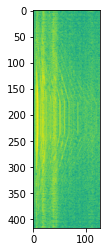

In [132]:
plt.imshow(a[3])

In [112]:
import random, glob, os
import numpy as np

import pydub
from pydub import AudioSegment
from pydub import effects
from utils.refactored_common import *
from tqdm.notebook import tqdm

try :
    from keras.utils import Sequence #   sequence =  keras.utils.Sequence
except:
    from keras.utils.all_utils import Sequence

import soundfile as sf
#import audioflux
from scipy import signal
#import librosa
import re


# ==================================================
def get_duration (fileName, duration=1, common=1):
    data, Fs = sf.read(fileName)
    file_duration = len(data)/Fs
    num_samples = 1 + int((file_duration - duration)/common)
    return file_duration, num_samples


# ==================================================
class Generator(Sequence):    
    
    def __init__(self, param, path='./data/tmp', batch_size=192,  genType="train", deriv_type=0, all_paths=False, debug=False) :
      
        self.shuffle= param["shuffle"] if genType != "test"  else False
        self.param = param
        self.n_fft = param['feature']['n_fft'] if param['feature']['Fs'] == 48000 else 2048 # 64 ms
        self.hop_length = param['feature']['hop_length'] #int(param['feature']['Fs']*0.025) # ~32 ms 24000*0.025
        self.win_length = self.n_fft
        self.Fs_Multiple = 0.5
        self.Fs = param["feature"]["Fs"]
        self.duration = param["feature"]["duration"]
        self.n_mels = param["feature"]["n_mels"]
        self.genType = genType

        self.mel_length = int((self.duration*self.Fs - self.n_fft + self.hop_length)/self.hop_length)

        self.batch_size  = batch_size # divide by 2
        self.class_dict  = param["generator"]['classes']
        self.num_classes = len(self.class_dict)
        classes_to_train = param["generator"]["classes_to_train"]
        dir_to_exclude = param["generator"]["dir_to_exclude"]
        deriv_config = param["generator"]["deriv_config"]
        overlap_config = param["generator"]["overlap_config"]
        class_to_map = param["generator"]["class_to_map"]
        self.num_peaks = param["generator"]["num_peaks"] # 0 indicates default config
        self.gen_mel = param["generator"]["gen_mel"]
        self.gen_spec = param["generator"]["gen_spec"]
        self.gen_mfcc = param["generator"]["gen_mfcc"]
        self.gen_stft = param["generator"]["gen_stft"]  
        self.gen_audio = param["generator"]["gen_audio"]  
        #print (class_to_map, overlap_config, deriv_config)

        # filename, exp_count, deriv_mode, overlap_mode, overlap, class_label
        self.file_list        = []
        
        path_list = []
        if type(path) is list:
            path_ = path
        else:
            path_ = [path]

        for p in path_:
            if classes_to_train == None:
                if all_paths :
                    path_list.append(os.path.join(p,"train"))
                    path_list.append(os.path.join(p,"val"))
                    path_list.append(os.path.join(p,"test"))
                else :
                    path_list.append(os.path.join(p, genType))

                if genType == "train":
                    if deriv_type != 0: 
                        path_list.append(os.path.join(p, "deriv_base"))
                    if deriv_type > 1 :
                        path_list.append(os.path.join(p, "deriv_lvl2"))
                    if deriv_type > 2 :
                        path_list.append(os.path.join(p, "deriv_mixed"))

            else :
                for cls in classes_to_train:
                    if all_paths :
                        path_list.append(os.path.join(p,"train", cls))
                        path_list.append(os.path.join(p,"val", cls))
                        path_list.append(os.path.join(p,"test", cls))
                    else :
                        path_list.append(os.path.join(p, genType, cls))
                    if genType == "train" :
                        if deriv_type != 0: 
                            path_list.append(os.path.join(p, "deriv_base", cls))
                        if deriv_type == 2 or deriv_type == 4:
                            path_list.append(os.path.join(p, "deriv_lvl2", cls))
                        if deriv_type == 3 or deriv_type == 4 :
                            path_list.append(os.path.join(p, "deriv_mixed", cls))     

        # print (path_list)
        self.total_avail = 0
        for p in path_list :
            for subdir, dirs, files in os.walk(p):
                # print (subdir, p, len(files))
                # print(p, len(files))
                if subdir == path : continue
                if classes_to_train == None and subdir == p : continue

                for t in dir_to_exclude :
                    if t in subdir :
                        files = []
                        print ("excluding", subdir)
                        continue
                #print (subdir)
                
                resample  = False
                deriv_cnt    = 1
                if self.genType != "test" :
                    for t in deriv_config:
                        if t in subdir :
                            resample = deriv_config[t]['resample']
                            deriv_cnt = deriv_config[t]['deriv_count']
                
                overlap_match = 0
                overlap_common = 1
                for t in overlap_config:
                    if t in subdir :
                        overlap_match = 1
                        overlap_common = overlap_config[t]["overlap_common"]

                # Lets include all the classes to allow for easier integration
                #if len(files) != 0: 
                classname = os.path.basename(subdir)
                if classname in ['mel', 'spec', 'mfcc', 'stft', 'wvlt'] : continue
                # check for remap
                # print(class_to_map)
                if classname in class_to_map :
                    print ("Overwrote ", classname, class_to_map[classname])
                    classname = class_to_map[classname]

                if classname not in self.class_dict :
                    label_id = self.num_classes
                    self.class_dict[classname] = self.num_classes
                    self.num_classes += 1
                else :
                    label_id = self.class_dict[classname]

                # print (len(files), classname)
                
                if self.num_peaks <= 1 :
                    files.sort()
                    for file in files:
                        fileName = os.path.join(subdir, file)
                        num_samples = 1
                        if overlap_match :
                            try :
                                _, num_samples = get_duration(fileName, duration=self.duration, common=overlap_common)
                            except: 
                                print ("Not able to read", fileName)
                                continue

                        num_samples *= 2 if resample else 1
                        #self.total_avail += num_samples
                        for i in range(deriv_cnt) :
                            self.file_list.append((fileName, num_samples, resample, overlap_match, overlap_common, label_id))
                            self.total_avail += num_samples
                    # print (len(files), classname, self.total_avail, num_samples, deriv_cnt, len(self.file_list))                 
                else :
                    files.sort()
                    base_files = dict()
                    # Get base names
                    for file in files:
                        f = re.split("_\d+.flac", file, 1)[0]
                        base_files[f] = base_files[f]+1 if f in base_files else 1
                    
                    for k,v  in base_files.items() :
                        if v != self.num_peaks :
                            print ("Orphan", k, v, self.num_peaks)
                            continue
                        else :
                            fileName = os.path.join(subdir, k)
                            num_samples = 1
                            num_samples *= 2 if resample else 1
                            for i in range(deriv_cnt) :
                                self.file_list.append((fileName, num_samples, resample, overlap_match, overlap_common, label_id))
                                self.total_avail += num_samples
                    # print (len(files), classname, self.total_avail, num_samples, deriv_cnt, len(self.file_list))                 


        # count available data
        # Sanity Check
        self.num_batches = self.total_avail//self.batch_size
        print (self.num_batches, self.total_avail, self.batch_size, len(self.file_list))
        
        # Support upto 4 threads
        #   20 files, get_item(index)
        #       Multiprocessing, index = 0, index = 1...
        #       20 files -> 5, 5, 5, 5
        #                 index %= 4 
        # 0 to 1/4 of the file list, 1/4 of file to 1/2 file lit, ...
        self.file_idx_ = [0, 0, 0, 0]
        self.file_off_ = [0, 0, 0, 0]

        #print (self.class_dict)
        #print (self.file_list)

        self.on_epoch_end()


    # ==================================
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return self.num_batches

    # ==================================
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.file_list)
        self.file_idx_ = [0, 0, 0, 0]
        self.file_off_ = [0, 0, 0, 0]


    # ==================================
    def get_class_info(self):
        return self.class_dict, self.num_classes

    # ==================================
    def __getitem__(self, index):
        # Disabling 4 threads for now
        batch_cnt = 0
        labels = []
        data_list = []
        tidx = index%4
        idx = self.file_idx_[tidx] 
        off = self.file_off_[tidx]
        filelist_off = int((tidx)*len(self.file_list)/4)

        #fileName, num_samples, resample, overlap_match, overlap_common, self.num_classes
        filelist_info = []

        while batch_cnt < self.batch_size:
            item = self.file_list[idx + filelist_off]
            remain_ = self.batch_size - batch_cnt
            resample = False if remain_ == 1 else item[2]
            num = -1
            if item[3] : # Overlap                
                num =  (item[1] - off) if remain_ >= (item[1] - off) else remain_
                num_ = (num + 1) // 2 if item[2] else num
                off_ = off // 2 if item[2] else off
                #print ("Iter:", num, remain_, off, num_, off_)
                result = self.prepare_overlap_data(item[0], entries_to_gen=num_, start_off=off_, duration=self.duration, overlap=item[4], resample=item[2])
                result = result[0:num]
            else :
                if self.num_peaks <= 1 :
                    # print ("Reading", item[0])
                    try :
                        result = self.read_data(item[0], resample=resample)
                    except :
                        result = None
                else :
                    r = []
                    for peak_id in range(self.num_peaks) :
                        file_2_read = f"{item[0]}_{peak_id}.flac"
                        try :
                            r.append(self.read_data(file_2_read, resample=resample)[0])
                            # print(item)
                        except :
                            break
                    
                    if len(r) != self.num_peaks :
                        result = None
                    else :
                        result = [r]
                    
            if result != None :
                data_list.extend(result)
                labels.extend([item[5]]*len(result))
                filelist_info.extend([item[0]]*len(result))
                batch_cnt += len(result)
                if item[3] :
                    off += 2*num_ if item[2] else num
                    assert off <= item[1]
                    if off >= item[1] :
                        idx += 1
                        off = 0
                else :
                    off = 0
                    idx += 1
            else :
                #assert False # Should never be here
                idx += 1
                off  = 0
            
            if True: 
                if len(self.file_list) < 4 :
                    idx  = 0
                else :
                    idx = idx % (len(self.file_list)//4)
            else :
                idx = idx % (len(self.file_list))

        assert len(data_list) == self.batch_size
        assert len(labels)   == self.batch_size

        self.file_idx_[tidx] = idx
        self.file_off_[tidx] = off

        labels = np.array(labels)
        data_list = np.array(data_list)
        n_values = self.num_classes
        y_test_onehot = np.eye(n_values)[labels]

        assert not np.any(np.isnan(data_list))
        
        if self.genType == "test" :
            return data_list, y_test_onehot, filelist_info
        else:
            return data_list, y_test_onehot

    #-----------------------------------
    def unzip_feature(self, path):
        feature = []
        # print(path)
        if os.path.exists(path) and os.path.isfile(path):
            f =  np.load(path)['f']
            if f.shape[0] > self.mel_length :
                i = random.randrange(0,f.shape[0]-self.mel_length)
                #print ("Load melpath", melpath, f.shape)
                feature.append(f[i:i+self.mel_length,:])
            elif f.shape[0] == self.mel_length:
                feature.append(f)  # feature.append([f])
            else :
                repeat_cnt = 1 + self.mel_length//f.shape[0]
                f_ = np.tile(f, (repeat_cnt,1))
                feature.append(f[0:self.mel_length,:])
            
        return feature

    # ==================================
    # Deriv can be 0, 1 
    def read_data (self, file, resample=False) :
        '''
        audioObj = pydub.AudioSegment.from_file(file)
        audioObj = audioObj.set_frame_rate(self.Fs)
        data_ = audioObj.get_array_of_samples()
        data_ = np.array(data_)/32768
        '''
        ## file <>/*.flac
        dirname = os.path.dirname(file)
        baseName = os.path.splitext(os.path.basename(file))[0]
        paths = []
        if self.gen_mel : paths.append(os.path.join(dirname, "mel", baseName+".npz"))
        if self.gen_spec: paths.append(os.path.join(dirname, "spec", baseName+".npz"))
        if self.gen_mfcc: paths.append(os.path.join(dirname, "mfcc", baseName+".npz"))
        if self.gen_stft: paths.append(os.path.join(dirname, "stft", baseName+".npz"))

        feature = []
        for path in paths:
            f = self.unzip_feature(path)
            if f:
                feature.extend(f)
            else:
                assert False, f"file not exist: {path}"
        
        if self.gen_audio:
            data, Fs_ = sf.read(file)
            feature.append(data)

        if feature:
            if len(feature) >1:
                return [np.array(feature)]
            else:
                return feature 
        else:
            return[None]
                
        try : 
            data, Fs_ = sf.read(file)
        except :
            #print ("Not able to read ", file)
            return None


        if Fs_ != self.Fs :
            n_ = int(len(data) * self.Fs / Fs_)
            data = signal.resample(data, n_)

        
        Fs = self.Fs

        data_list = []
        if len(data) <= self.duration*self.Fs:
            if len(data) <= (self.duration+0.01)*self.Fs :
                num = int((self.duration+0.01)*self.Fs/len(data)) + 1
                data2 = []
                for i in range(num) :
                    data2.extend(data)
            else :
                data2 = data
                
            #print (len(data), len(data2), num, self.Fs, self.duration)
            data = np.array(data2[0:int(self.Fs*self.duration)])
            t = gen_mel_feature (data, self.Fs, self.n_fft, self.hop_length, self.win_length, self.n_mels)
            #print (t.shape)
            data_list.append(t)
        else :
            i = random.randrange(0,7)

            start_idx = int(0.034*i*Fs) + (len(data) - self.duration*self.Fs)//2
            stop_idx  = start_idx + int(self.duration*self.Fs)

            # print("start",start_idx, "stop", stop_idx, "total", stop_idx-start_idx,"len of orig",len(data), len(data [start_idx:stop_idx]))

            data_list.append(gen_mel_feature ( data [start_idx:stop_idx], Fs, self.n_fft, self.hop_length, self.win_length, self.n_mels))

            if resample:
                Fs2 = int(self.Fs_Multiple*Fs)
                n_ = int(len(data) * self.Fs_Multiple)
                data2 = signal.resample(data, n_)
                n_fft2      = 4096 if Fs2 == 48000 else 2048
                hop_length2 = int(self.Fs_Multiple*self.hop_length) # ~20 ms 24000*0.025
                win_length2 = n_fft2

                start_idx2 = int(self.Fs_Multiple*start_idx)
                stop_idx2  = start_idx2 + int(self.duration*Fs2)

                data_list.append(gen_mel_feature ( data2[start_idx2:stop_idx2], Fs2, n_fft2, hop_length2, win_length2, self.n_mels))

        return data_list
    
                             
    # ==================================
    def getitem(self, index):
        return self.__getitem__(index)


